In [0]:
! pip install pydicom nibabel SimpleITK pyradiomics

In [0]:
from __future__ import print_function
import os, sys
import logging
import six, csv
import numpy as np
import pandas as pd
import glob
import tqdm

# import matplotlib
# matplotlib.use("AGG")
import matplotlib.pyplot as plt

import pydicom as dicom
import nibabel as nib

import SimpleITK as sitk

import radiomics
from radiomics import featureextractor
from radiomics import firstorder, glcm, imageoperations, shape, glrlm, glszm

In [0]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, Input, GRU, Bidirectional, GlobalAveragePooling1D, Concatenate
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.optimizers import Adam, SGD, RMSprop
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical

In [0]:
vgg = VGG16(weights='imagenet', include_top=False)

W0619 19:12:31.328336 140671300331392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0619 19:12:31.346823 140671300331392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0619 19:12:31.349363 140671300331392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0619 19:12:31.376992 140671300331392 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0619 19:12:31.696445 140671300331392 deprecation_wrapp

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
def load_nii_gz(label_fpath, transpose=False):
    data = nib.load(label_fpath)
    pixel_array = data.get_fdata()
    if transpose:
        pixel_array = np.transpose(pixel_array, axes=(2,1,0))
    return pixel_array 

In [0]:
cd "/content/gdrive/My Drive/projects/ClinicAI/FinalProject/"

/content/gdrive/My Drive/projects/ClinicAI/FinalProject


In [0]:
X = np.load("X_train.npz")
X_vgg = np.load("X_vgg.npz")
X_radiomics = np.load("X_radiomicsFeatures.npz")
y = np.load("y_survival.npy")

In [0]:
y 

array([1155,  614,  698,  439,  180,  616,  375,  152,  522,  120,  172,
        726,  510,  453,  350,  788,  114,  169, 1767, 1283,  168,  473,
        401,  515,  287,  106,  139,  331,  448,  376, 1592,  660,  576,
        465,  503,  495,  486,  368,   50])

* 0:  short-survivors (<10 months) 
* 1:  mid-survivors (between 10 and 15 months)
* 2: long-survivors (>15 months)

---




In [0]:
def get_survival_class(days):
    if days < 10 * 30:
        return 0
    elif days < 15 * 30:
        return 1
    else:
        return 2

In [0]:
y_class = np.array([get_survival_class(day) for day in y])

In [0]:
y_class

array([2, 2, 2, 1, 0, 2, 1, 0, 2, 0, 0, 2, 2, 2, 1, 2, 0, 0, 2, 2, 0, 2,
       1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0])

In [0]:
# np.save("y_survival_class", y_class)

In [0]:
unique, counts = np.unique(y_class, return_counts=True)
dict(zip(unique, counts))

{0: 11, 1: 8, 2: 20}

In [0]:
to_categorical(y_class).shape

(39, 3)

In [0]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, \
                             verbose=2, mode='auto', baseline=None, restore_best_weights=False)

In [0]:
def radiomicsANN():
    radiomics = Input((13560,))
    
    x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.05))(radiomics)
    x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
#     output = Dense(3, activation='softmax') (x)
    output = Dense(1) (x)
    
    model = Model(inputs=radiomics, outputs=output)
    model.compile(loss='mse', optimizer=Adam(lr=3e-4))
#     model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=3e-4), metrics=['accuracy'])

    return model
   

In [0]:
ANN = radiomicsANN()
ANN.summary()

W0620 01:37:39.446841 139657102509952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0620 01:37:39.496743 139657102509952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0620 01:37:39.507419 139657102509952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0620 01:37:39.569966 139657102509952 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 13560)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                216976    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 217,265
Trainable params: 217,265
Non-trainable params: 0
_________________________________________________________________


In [0]:
radiomicsFeatures = []
for i in X_radiomics.items():
    print(i[0])
    if i[0]!="featureName":
        radiomicsFeatures.append(i[1])

t1_1
t1_2
t1_4
t1ce_1
t1ce_2
t1ce_4
t2_1
t2_2
t2_4
flair_1
flair_2
flair_4
featureName


In [0]:
X_radFeatures = np.concatenate(radiomicsFeatures[:], axis=1)

In [0]:
X_radFeatures.shape

(39, 13560)

In [0]:
# history = ANN.fit(X_radFeatures, to_categorical(y_class), batch_size=4, epochs=400, validation_split=0.25, callbacks=[callback])


Train on 29 samples, validate on 10 samples
Epoch 1/400
29/29 [==============================] - 0s 13ms/step - loss: 12.7783 - acc: 0.3448 - val_loss: 14.8204 - val_acc: 0.2000
Epoch 2/400
29/29 [==============================] - 0s 1ms/step - loss: 11.7720 - acc: 0.3793 - val_loss: 12.8295 - val_acc: 0.3000
Epoch 3/400
29/29 [==============================] - 0s 1ms/step - loss: 11.9908 - acc: 0.3448 - val_loss: 12.5533 - val_acc: 0.3000
Epoch 4/400
29/29 [==============================] - 0s 1ms/step - loss: 11.7484 - acc: 0.3448 - val_loss: 12.3588 - val_acc: 0.3000
Epoch 5/400
29/29 [==============================] - 0s 1ms/step - loss: 11.5796 - acc: 0.3448 - val_loss: 13.8375 - val_acc: 0.2000
Epoch 6/400
29/29 [==============================] - 0s 1ms/step - loss: 11.4649 - acc: 0.3448 - val_loss: 13.7480 - val_acc: 0.2000
Epoch 7/400
29/29 [==============================] - 0s 1ms/step - loss: 11.3881 - acc: 0.3448 - val_loss: 12.0764 - val_acc: 0.3000
Epoch 8/400
29/29 [=====

In [0]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X_radFeatures, y, random_state=42, test_size=0.25)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(29, 13560) (10, 13560) (29,) (10,)


In [0]:
# history = ANN.fit(X_radFeatures, y, batch_size=4, epochs=400, validation_split=0.25, callbacks=[callback])
history = ANN.fit(xtrain, ytrain, batch_size=4, epochs=400, validation_data=(xtest,ytest), callbacks=[callback])

Train on 29 samples, validate on 10 samples
Epoch 1/400
29/29 [==============================] - 0s 2ms/step - loss: 16446696997618794.0000 - val_loss: 8557997664816333.0000
Epoch 2/400
29/29 [==============================] - 0s 1ms/step - loss: 16378400077196324.0000 - val_loss: 8673824537470566.0000
Epoch 3/400
29/29 [==============================] - 0s 1ms/step - loss: 16260776232385430.0000 - val_loss: 9164672576415334.0000
Epoch 4/400
29/29 [==============================] - 0s 1ms/step - loss: 16093147392620898.0000 - val_loss: 9540179724966298.0000
Epoch 5/400
29/29 [==============================] - 0s 1ms/step - loss: 15975104809108586.0000 - val_loss: 10056143115334452.0000
Epoch 6/400
29/29 [==============================] - 0s 1ms/step - loss: 15816772941521742.0000 - val_loss: 10256321061951898.0000
Epoch 00006: early stopping


In [0]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor


In [0]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

sfm = SelectFromModel(rf, threshold=1e-4)


In [0]:
# sfm.fit(X_radFeatures, y)
sfm.fit(xtrain, ytrain)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                                max_depth=40,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=2,
                                                min_samples_split=10,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=2000, n_jobs=-1,
                                                oob_score=True, random_state=42,
                                                verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False,
                threshold=0.0001)

In [0]:
X_sel_1e_4 = sfm.transform(xtrain)

In [0]:
X_sel_1e_4.shape

(29, 1565)

In [0]:
def radiomicsANN2():
    radiomics = Input((1565,))
    
    x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.05))(radiomics)
    x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
#     output = Dense(3, activation='softmax') (x)
    output = Dense(1) (x)
    
    model = Model(inputs=radiomics, outputs=output)
    model.compile(loss='mse', optimizer=Adam(lr=3e-4))
#     model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=3e-4), metrics=['accuracy'])

    return model
   

In [0]:
ANN2 = radiomicsANN2()

In [0]:
# history2 = ANN2.fit(X_sel_1e_4, to_categorical(y_class), batch_size=4, epochs=400, validation_split=0.25, callbacks=[callback])

In [0]:
history2 = ANN2.fit(X_sel_1e_4, ytrain, batch_size=4, epochs=400, validation_split=0.25, callbacks=[callback])

Train on 21 samples, validate on 8 samples
Epoch 1/400
21/21 [==============================] - 0s 14ms/step - loss: 8000086516102.0947 - val_loss: 13192918990848.0000
Epoch 2/400
21/21 [==============================] - 0s 1ms/step - loss: 6095805280670.4756 - val_loss: 12083126747136.0000
Epoch 3/400
21/21 [==============================] - 0s 1ms/step - loss: 4773699916361.1426 - val_loss: 11273979232256.0000
Epoch 4/400
21/21 [==============================] - 0s 1ms/step - loss: 3049294628376.3809 - val_loss: 10304029982720.0000
Epoch 5/400
21/21 [==============================] - 0s 1ms/step - loss: 2346339956638.4761 - val_loss: 9614022836224.0000
Epoch 6/400
21/21 [==============================] - 0s 979us/step - loss: 1961168040911.2380 - val_loss: 9109436268544.0000
Epoch 7/400
21/21 [==============================] - 0s 1ms/step - loss: 1514941741543.6189 - val_loss: 8407355260928.0000
Epoch 8/400
21/21 [==============================] - 0s 1ms/step - loss: 1145651136804.57

In [0]:
sfm2 = SelectFromModel(rf, threshold=1e-3)

In [0]:
sfm2.fit(xtrain, ytrain)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                                max_depth=40,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=2,
                                                min_samples_split=10,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=2000, n_jobs=-1,
                                                oob_score=True, random_state=42,
                                                verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=0.001)

In [0]:
X_sel_1e_3 = sfm2.transform(xtrain)
X_sel_1e_3.shape

(29, 207)

In [0]:
def radiomicsANN3():
    radiomics = Input((207,))
    
    x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.05))(radiomics)
    x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
#     output = Dense(3, activation='softmax') (x)
    output = Dense(1) (x)
    
    model = Model(inputs=radiomics, outputs=output)
    model.compile(loss='mse', optimizer=Adam(lr=3e-4))
#     model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=3e-4), metrics=['accuracy'])

    return model
   

In [0]:
ANN3 = radiomicsANN3()

In [0]:
history3 = ANN3.fit(X_sel_1e_3, ytrain, batch_size=4, epochs=400, validation_data=(sfm2.transform(xtest),ytest), callbacks=[callback])

Train on 29 samples, validate on 10 samples
Epoch 1/400
29/29 [==============================] - 0s 1ms/step - loss: 68936472946.7586 - val_loss: 3772677120.0000
Epoch 2/400
29/29 [==============================] - 0s 974us/step - loss: 58322472271.4483 - val_loss: 4796759756.8000
Epoch 3/400
29/29 [==============================] - 0s 1ms/step - loss: 48307860488.8276 - val_loss: 6015584563.2000
Epoch 4/400
29/29 [==============================] - 0s 989us/step - loss: 38742775352.8276 - val_loss: 6976029849.6000
Epoch 5/400
29/29 [==============================] - 0s 898us/step - loss: 34308546647.9310 - val_loss: 8128411136.0000
Epoch 6/400
29/29 [==============================] - 0s 970us/step - loss: 30200116850.7586 - val_loss: 9266382438.4000
Epoch 00006: early stopping


In [0]:
sfm3 = SelectFromModel(rf, threshold=5e-3)
# sfm3.fit(X_radFeatures, y)
sfm3.fit(xtrain, ytrain)
X_sel_5e_3 = sfm3.transform(xtrain)
X_sel_5e_3.shape

(29, 12)

In [0]:
def radiomicsANN4():
    radiomics = Input((12,))
    
    x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.05))(radiomics)
    x = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
#     output = Dense(3, activation='softmax') (x)
    output = Dense(1) (x)
    
    model = Model(inputs=radiomics, outputs=output)
    model.compile(loss='mse', optimizer=Adam(lr=3e-4))
#     model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=3e-4), metrics=['accuracy'])

    return model
   

In [0]:
ANN4 = radiomicsANN4()
history4 = ANN4.fit(X_sel_5e_3, ytrain, batch_size=4, epochs=400, validation_data=(sfm3.transform(xtest),ytest), callbacks=[callback])

Train on 29 samples, validate on 10 samples
Epoch 1/400
29/29 [==============================] - 0s 13ms/step - loss: 1740562.1348 - val_loss: 798786.8156
Epoch 2/400
29/29 [==============================] - 0s 1ms/step - loss: 1524954.9089 - val_loss: 762392.2188
Epoch 3/400
29/29 [==============================] - 0s 1ms/step - loss: 1401128.4133 - val_loss: 722338.8281
Epoch 4/400
29/29 [==============================] - 0s 1ms/step - loss: 1301062.5356 - val_loss: 680925.2656
Epoch 5/400
29/29 [==============================] - 0s 1ms/step - loss: 1159958.2112 - val_loss: 647202.5344
Epoch 6/400
29/29 [==============================] - 0s 1ms/step - loss: 1064601.9898 - val_loss: 614379.5687
Epoch 7/400
29/29 [==============================] - 0s 1ms/step - loss: 952181.4230 - val_loss: 587429.5094
Epoch 8/400
29/29 [==============================] - 0s 1ms/step - loss: 847489.8260 - val_loss: 566313.7531
Epoch 9/400
29/29 [==============================] - 0s 1ms/step - loss: 8064

In [0]:
ANN4_2 = radiomicsANN4()
history4_2 = ANN4_2.fit(X_sel_5e_3, ytrain, batch_size=4, epochs=1000, validation_data=(sfm3.transform(xtest),ytest))

Train on 29 samples, validate on 10 samples
Epoch 1/1000
29/29 [==============================] - 1s 23ms/step - loss: 4298856.8534 - val_loss: 1494315.3500
Epoch 2/1000
29/29 [==============================] - 0s 988us/step - loss: 4147603.0690 - val_loss: 1449327.3813
Epoch 3/1000
29/29 [==============================] - 0s 1ms/step - loss: 4005178.7500 - val_loss: 1413544.5375
Epoch 4/1000
29/29 [==============================] - 0s 995us/step - loss: 3888799.9343 - val_loss: 1378352.0813
Epoch 5/1000
29/29 [==============================] - 0s 982us/step - loss: 3751294.8642 - val_loss: 1350342.9625
Epoch 6/1000
29/29 [==============================] - 0s 1ms/step - loss: 3651767.3610 - val_loss: 1319636.8000
Epoch 7/1000
29/29 [==============================] - 0s 896us/step - loss: 3530949.0905 - val_loss: 1278856.6375
Epoch 8/1000
29/29 [==============================] - 0s 978us/step - loss: 3398599.2004 - val_loss: 1228358.2312
Epoch 9/1000
29/29 [=============================

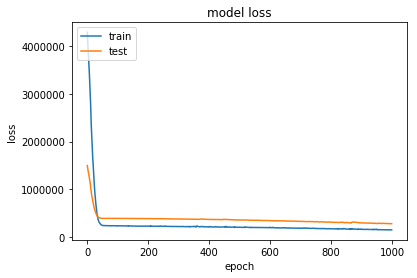

In [0]:
plt.plot(history4_2.history['loss'])
plt.plot(history4_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

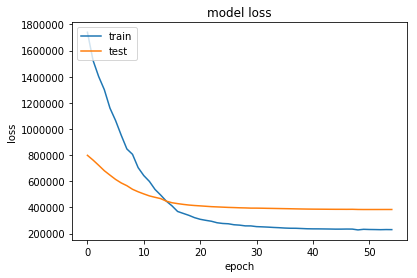

In [0]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
y_pred4 = ANN4.predict(X_sel_5e_3)
y_pred4

array([[ 113.936165 ],
       [1584.7219   ],
       [  66.05876  ],
       [   1.9085178],
       [ 443.6646   ],
       [  52.23101  ],
       [   4.625974 ],
       [ 802.0226   ],
       [ 348.55402  ],
       [   8.142271 ],
       [ 252.73718  ],
       [  61.1585   ],
       [  79.5475   ],
       [  48.9078   ],
       [  16.52607  ],
       [  39.137074 ],
       [  11.30635  ],
       [  24.693678 ],
       [   6.872525 ],
       [  23.470667 ],
       [ 322.51996  ],
       [  71.43016  ],
       [ 182.57025  ],
       [ 769.4617   ],
       [ 152.77153  ],
       [  43.37625  ],
       [ 152.86713  ],
       [  13.090026 ],
       [   5.2465453]], dtype=float32)

In [0]:
sel_idx = sfm3.get_support(indices=True)

for i in sel_idx:
    group = i//1130
    if(group %3 == 0):
        label = 1
    elif(group %3 == 1):
        label = 2 
    else:
        label = 4
    
    if(group // 3 == 0):
        modality = 't1'
    elif(group // 3 == 1):
        modality = 't1ce'
    elif(group // 3 == 2):
        modality = 't2'
    else:
        modality = 'flair'
    print(modality, label, X_radiomics["featureName"][i%1130])

t1 2 original_firstorder_Minimum
t1 2 log-sigma-2-mm-3D_ngtdm_Complexity
t1 4 log-sigma-2-mm-3D_gldm_DependenceEntropy
t1ce 1 wavelet-LHL_glcm_Imc1
t1ce 1 wavelet-HLL_firstorder_Variance
t1ce 1 wavelet-HHL_firstorder_RobustMeanAbsoluteDeviation
t1ce 4 wavelet-HHL_firstorder_Skewness
t2 1 log-sigma-2-mm-3D_glcm_ClusterShade
t2 4 wavelet-HLL_glcm_ClusterShade
t2 4 log-sigma-2-mm-3D_glcm_Idn
flair 4 wavelet-HHH_glcm_SumSquares
flair 4 log-sigma-3-mm-3D_ngtdm_Busyness


In [0]:
from joblib import dump, load
dump(sfm3, "select_rf_5e_3.joblib")
dump(sfm2, "select_rf_1e_3.joblib")

['select_rf_1e_3.joblib']

In [0]:
testLoad = load("select_rf_1e_3.joblib")

In [0]:
testLoad.get_support(indices=True)

array([  301,   397,   443,   444,   469,   769,   772,   950,  1029,
        1095,  1126,  1132,  1154,  1432,  1480,  1644,  1646,  1898,
        2081,  2093,  2100,  2102,  2103,  2164,  2240,  2241,  2266,
        2267,  2284,  2316,  2318,  2429,  2470,  2481,  2483,  2559,
        2694,  2697,  2698,  2796,  2819,  2842,  3028,  3060,  3062,
        3117,  3173,  3199,  3210,  3236,  3238,  3246,  3255,  3266,
        3359,  3418,  3596,  3597,  3602,  3603,  3607,  3613,  3621,
        3622,  3777,  3780,  3788,  3789,  3793,  3962,  3966,  3969,
        3974,  4248,  4253,  4325,  4354,  4497,  4521,  4522,  5483,
        5576,  5577,  5656,  5674,  5706,  5708,  5778,  5851,  5854,
        5859,  5871,  5873,  5881,  5913,  6011,  6020,  6030,  6037,
        6040,  6043,  6048,  6093,  6094,  6226,  6236,  6372,  6450,
        6501,  6514,  6524,  6612,  6615,  6626,  6651,  6684,  6718,
        6719,  6724,  6729,  6750,  6775,  7167,  7744,  7796,  8000,
        8011,  8186,

In [0]:
def lstm():
    vgg = Input((155, 25088))
    age = Input((1,))
#     x = BatchNormalization()(vgg)
#     x = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
# #     x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
#     x = Dropout(0.2)(x)
    
#     x = BatchNormalization()(x)
#     x = Dense(4096, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
# #     x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
#     x = Dropout(0.2)(x)
    
    rnn_output = Bidirectional(
        LSTM(512, dropout=0.2, kernel_regularizer=regularizers.l2(0.05), return_sequences=True), merge_mode='sum'
    )(vgg)
    
    x = GlobalAveragePooling1D()(rnn_output) 
#     x = TimeDistributed(Dense(256))(rnn_output) 

    
    concat_age = Concatenate()([x , age])
    
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.05))(concat_age)
    x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
    
    outputs = Dense(3, activation='softmax')(x)
    
    
    model = Model(inputs=[vgg, age], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=3e-4), metrics=['accuracy'])
    return model
    

In [0]:
model = lstm()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 155, 25088)   0                                            
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 155, 512)     104861696   input_8[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_4 (Glo (None, 512)          0           bidirectional_4[0][0]            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
concatenat

In [0]:
history = model.fit([X_vgg['flair'], X['age']], to_categorical(y_class), batch_size=8, epochs=400, validation_split=0.25, callbacks=[callback])

Train on 29 samples, validate on 10 samples
Epoch 1/400
29/29 [==============================] - 26s 885ms/step - loss: 370.0720 - acc: 0.2759 - val_loss: 316.3353 - val_acc: 0.7000
Epoch 2/400
29/29 [==============================] - 15s 503ms/step - loss: 293.1129 - acc: 0.4483 - val_loss: 248.5790 - val_acc: 0.7000
Epoch 3/400
29/29 [==============================] - 15s 505ms/step - loss: 229.0665 - acc: 0.4483 - val_loss: 193.0238 - val_acc: 0.2000
Epoch 4/400
29/29 [==============================] - 15s 507ms/step - loss: 176.8659 - acc: 0.4483 - val_loss: 147.7522 - val_acc: 0.7000
Epoch 5/400
29/29 [==============================] - 15s 503ms/step - loss: 135.1728 - acc: 0.4483 - val_loss: 112.3250 - val_acc: 0.8000
Epoch 6/400
29/29 [==============================] - 15s 505ms/step - loss: 102.5841 - acc: 0.4828 - val_loss: 85.1502 - val_acc: 0.5000
Epoch 7/400
29/29 [==============================] - 15s 502ms/step - loss: 77.7445 - acc: 0.5517 - val_loss: 64.5878 - val_acc: 

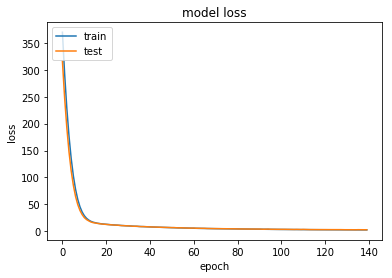

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('train_loss.png')

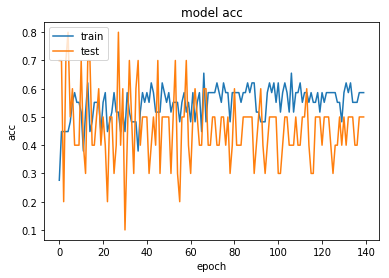

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('train_acc.png')

In [0]:
preds = model.predict([X_vgg['flair'],X['age']])

In [0]:
preds.argmax(axis=-1)

In [0]:
for i in range(39):
    print(preds[i].argmax(axis=-1),"\t", y_class[i])

2 	 2
2 	 2
2 	 2
2 	 1
2 	 0
2 	 2
2 	 1
0 	 0
0 	 2
0 	 0
0 	 0
0 	 2
2 	 2
2 	 2
2 	 1
2 	 2
0 	 0
2 	 0
2 	 2
2 	 2
0 	 0
0 	 2
2 	 1
2 	 2
0 	 0
0 	 0
2 	 0
2 	 1
2 	 1
0 	 1
2 	 2
2 	 2
2 	 2
0 	 2
0 	 2
0 	 2
2 	 2
2 	 1
0 	 0


In [0]:
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error(y, preds)
MSE

396398.1010711665

In [0]:
def getRadiomicsResult(modality, X_image, X_seg, target=1):
    # Get the PyRadiomics logger (default log-level = INFO)
    logger = radiomics.logger
    logger.setLevel(logging.DEBUG)  # set level to DEBUG to include debug log messages in log file

    # Write out all log entries to a file
    if not os.path.exists("./log"):
        os.makedirs("./log")

    handler = logging.FileHandler(filename='./log/testLog.txt', mode='w')
    formatter = logging.Formatter('%(levelname)s:%(name)s: %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    
    ### Initialize Feature Extractor ###
    
    # First define the settings
    settings = {}
    # settings['binWidth'] = 20
    settings['sigma'] = [1, 2, 3]
    settings['distances'] = [2]
    settings['label'] = target # 1 or 2 or 4
    if modality != "t2":
        settings['normalize'] = True
    settings['resampledPixelSpacing'] = [1, 1, 1]
    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
    
    try:
        import tqdm
        radiomics.progressReporter = tqdm.tqdm
        extractor.settings['enableCExtensions'] = True

        extractor.enableImageTypeByName('Wavelet')
        extractor.enableImageTypeByName('LoG')
   
        radiomics.setVerbosity(logging.INFO)  # Verbosity must be at least INFO to enable progress bar
    except ImportError:
        pass  # tqdm package not available, skip setting up the progressbar for tqdm

    ### execute ###
    
    featureVectors = []
    for (image, label) in tqdm.tqdm(zip(X_flair, X_seg)):
        featureVector = extractor.execute( \
            sitk.GetImageFromArray(image.T), sitk.GetImageFromArray(label.T))
        featureVectors.append(featureVector)
        
    extracted_features = []

    for orded_dict in featureVectors:
        feature = []
        featureName = []
        for key, value in orded_dict.items():
            if not key.startswith("diagnostics_"):
                feature.append(value)
                featureName.append(key)
        feature = np.array(feature)
        extracted_features.append(feature)

    extracted_features = np.array(extracted_features)
    np.save(modality + "_label" + str(target) + ".npy", extracted_features)
    
    return extracted_features

In [0]:
rf_test = RandomForestRegressor(bootstrap=True, criterion='mse',
                                                max_depth=40,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=2,
                                                min_samples_split=10,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=2000, n_jobs=-1,
                                                oob_score=True, random_state=42,
                                                verbose=0, warm_start=False)

In [0]:
rf_test.fit(X_radFeatures, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

# TEST

In [0]:
test_image_folder = "./test-images/image/"

sample_submission = np.genfromtxt('./sample_submission.csv', 
                                  delimiter=',', 
                                  dtype='str',
                                  skip_header = 1)
test_encode_list = sample_submission[:, 0]

In [0]:
test_X_t1 = np.zeros((len(test_encode_list), 155, 240, 240))
test_X_t1ce = np.zeros((len(test_encode_list), 155, 240, 240))
test_X_t2 = np.zeros((len(test_encode_list), 155, 240, 240))
test_X_flair = np.zeros((len(test_encode_list), 155, 240, 240))
test_X_seg = np.zeros((len(test_encode_list), 155, 240, 240))
for i, encode in enumerate(test_encode_list):
    test_X_t1[i, :, :, :] = load_nii_gz(os.path.join(test_image_folder, encode, 't1.nii.gz'), transpose=True)
    test_X_t1ce[i, :, :, :] = load_nii_gz(os.path.join(test_image_folder, encode, 't1ce.nii.gz'), transpose=True)
    test_X_t2[i, :, :, :] = load_nii_gz(os.path.join(test_image_folder, encode, 't2.nii.gz'), transpose=True)
    test_X_flair[i, :, :, :] = load_nii_gz(os.path.join(test_image_folder, encode, 'flair.nii.gz'), transpose=True)
    test_X_seg[i, :, :, :] = load_nii_gz(os.path.join(test_image_folder, encode, 'seg.nii.gz'), transpose=True)

In [0]:
test_df = pd.read_csv("./test-age.csv")
test_df = test_df.drop(columns=["Unnamed: 0"])
test_df.reset_index(drop=True, inplace=True)
test_df

,Encode,Age
0,4zqmljfrc675dtrky3gchyx87jkl3czk,29.120
1,t6if2ohjnd7mh06z81wwd3sp86h427ad,63.781
2,7rmkmfclt0mkmqs5b3e6rny5hwgwo11y,65.921
3,chjxxykw2lz1v37hgriyniblgi41d5y3,79.211
4,orhcxlyoc0x6idbzlqmbsdqduehdy75o,85.762
5,7rxxiwwbbxy0yoatpsyltln3v2wtne9e,72.293
6,0r3e6ezursuo5y6m3jwpztq763cjki0p,63.359
7,haz4ax59boce4twwwpzfq7hwydgqn9we,70.252
8,zcn7u2kqbrqlzgf07yzzjg5mqyqgqul1,51.589
9,27w6sraww3g2ui9fxpu08tcgyocprtqg,69.178


In [0]:
test_X_age = np.array(test_df['Age'])
test_X_age = test_X_age.reshape(20,1)

In [0]:
test_X_seg.shape

(20, 155, 240, 240)

In [0]:
np.savez_compressed("X_test", t1=test_X_t1, t1ce=test_X_t1ce, t2=test_X_t2, flair=test_X_flair, seg=test_X_seg, age=test_X_age)

In [0]:
modality = ['t1', 't1ce', 't2', 'flair']

In [0]:
X_test = np.load("X_test.npz")

In [0]:
X_test["t1"].shape

(20, 155, 240, 240)

In [0]:
def getRadiomicsResult(modality, X_image, X_seg, target=1):
    # Get the PyRadiomics logger (default log-level = INFO)
    logger = radiomics.logger
    logger.setLevel(logging.DEBUG)  # set level to DEBUG to include debug log messages in log file

    # Write out all log entries to a file
    if not os.path.exists("./log"):
        os.makedirs("./log")

    handler = logging.FileHandler(filename='./log/testLog.txt', mode='w')
    formatter = logging.Formatter('%(levelname)s:%(name)s: %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    
    ### Initialize Feature Extractor ###
    
    # First define the settings
    settings = {}
    # settings['binWidth'] = 20
    settings['sigma'] = [1, 2, 3]
    settings['distances'] = [2]
    settings['label'] = target # 1 or 2 or 4
    if modality != "t2":
        settings['normalize'] = True
    settings['resampledPixelSpacing'] = [1, 1, 1]
    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
    
    try:
        import tqdm
        radiomics.progressReporter = tqdm.tqdm
        extractor.settings['enableCExtensions'] = True

        extractor.enableImageTypeByName('Wavelet')
        extractor.enableImageTypeByName('LoG')
   
        radiomics.setVerbosity(logging.INFO)  # Verbosity must be at least INFO to enable progress bar
    except ImportError:
        pass  # tqdm package not available, skip setting up the progressbar for tqdm

    ### execute ###
    
    featureVectors = []
    for (image, label) in tqdm.tqdm(zip(X_image, X_seg)):
        featureVector = extractor.execute( \
            sitk.GetImageFromArray(image.T), sitk.GetImageFromArray(label.T))
        featureVectors.append(featureVector)
        
    extracted_features = []

    for orded_dict in featureVectors:
        feature = []
        featureName = []
        for key, value in orded_dict.items():
            if not key.startswith("diagnostics_"):
                feature.append(value)
                featureName.append(key)
        feature = np.array(feature)
        extracted_features.append(feature)

    extracted_features = np.array(extracted_features)
    np.save(modality + "_label" + str(target) + ".npy", extracted_features)
    
    return extracted_features

In [0]:
# for mod in modality:
#     for label in [1,2,4]:
#         print(mod, label)
#         getRadiomicsResult(mod, X_test[mod], X_test["seg"], label)

In [0]:
# test_flair = []
# for x in test_X_flair:
#     x = skimage.transform.resize(x, (155,224,224))
#     x = skimage.color.gray2rgb(x) 
#     test_flair.append(vgg.predict(x).reshape(155,-1))
# test_X_flair = np.array(test_flair)

In [0]:
test_preds = ANN4.predict(sfm3.transform(X_test_radiomics_features))

In [0]:
test_preds = ANN4_2.predict(sfm3.transform(X_test_radiomics_features))

In [0]:
test_preds = model.predict([test_X_flair, test_X_age])

In [0]:
test_test =rf_test.predict(X_test_radiomics_features)

In [0]:
sfm3.transform(X_test_radiomics_features).shape

(20, 12)

In [0]:
rf_test2= rf_test
rf_test2.fit(sfm3.transform(X_radFeatures), y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
test_test_test = rf_test2.predict(sfm3.transform(X_test_radiomics_features))

In [0]:
solution_path = './rf_sfm3.csv'
with open(solution_path, 'w') as f:
    f.write('Encode,Survival\n')
    for i, encode in enumerate(test_encode_list):
        print(encode, test_test_test[i]) 
        f.write(encode + ',' + str(test_test_test[i]) + '\n')

4zqmljfrc675dtrky3gchyx87jkl3czk 976.5678610959791
t6if2ohjnd7mh06z81wwd3sp86h427ad 305.8111839574299
7rmkmfclt0mkmqs5b3e6rny5hwgwo11y 528.3061662887769
chjxxykw2lz1v37hgriyniblgi41d5y3 338.15067964880444
orhcxlyoc0x6idbzlqmbsdqduehdy75o 530.0062230944551
7rxxiwwbbxy0yoatpsyltln3v2wtne9e 342.2144583445511
0r3e6ezursuo5y6m3jwpztq763cjki0p 424.7293657128996
haz4ax59boce4twwwpzfq7hwydgqn9we 396.014957189936
zcn7u2kqbrqlzgf07yzzjg5mqyqgqul1 500.0357123961567
27w6sraww3g2ui9fxpu08tcgyocprtqg 357.5847297793065
sedxnmxte7gxrdbbpx8p8b3jhurlrx3n 387.34255972310325
ji97woc3vcyn9lzq5xfpk3j95i5vswmm 300.33267255333055
09amv752acxnzvkfughexk0wilhxdtd5 477.4476081521186
gg4o6f2xyb2zpclttmjy35lqnasg9vz4 345.0977427377211
hjhau2e5j5p1zpwbbuocjiwplq20l2dz 277.3532381289395
2398n5c5yz5km503of24gbxdb803gq5q 288.8392886716221
do2ausaft9rrqogh8y16qb0vuy5roywm 376.2231160581869
tspn2x2dggh1ugi1vizmvcrsll644p2a 460.47423315772494
djquj44l7imhygd741v81p9gfc4nu5xk 254.73976244217124
jbhvvv6rpu7mbs5bpu1byb31c9y

In [0]:
test_test

array([640.58300463, 405.48006106, 566.78229704, 430.47337139,
       516.08574071, 680.54104837, 462.5326229 , 422.25730786,
       527.9340675 , 669.44992234, 496.07732394, 362.39395785,
       633.60104094, 437.28606117, 452.73963157, 523.77385195,
       387.04947408, 573.26182608, 477.40250023, 719.83513586])

In [0]:
solution_path = './rf.csv'
with open(solution_path, 'w') as f:
    f.write('Encode,Survival\n')
    for i, encode in enumerate(test_encode_list):
        print(encode, test_test[i]) 
        f.write(encode + ',' + str(test_test[i]) + '\n')

4zqmljfrc675dtrky3gchyx87jkl3czk 640.583004633689
t6if2ohjnd7mh06z81wwd3sp86h427ad 405.48006105626445
7rmkmfclt0mkmqs5b3e6rny5hwgwo11y 566.7822970350442
chjxxykw2lz1v37hgriyniblgi41d5y3 430.47337139369904
orhcxlyoc0x6idbzlqmbsdqduehdy75o 516.0857407052348
7rxxiwwbbxy0yoatpsyltln3v2wtne9e 680.5410483678538
0r3e6ezursuo5y6m3jwpztq763cjki0p 462.5326228953903
haz4ax59boce4twwwpzfq7hwydgqn9we 422.2573078586255
zcn7u2kqbrqlzgf07yzzjg5mqyqgqul1 527.9340675042275
27w6sraww3g2ui9fxpu08tcgyocprtqg 669.4499223427925
sedxnmxte7gxrdbbpx8p8b3jhurlrx3n 496.07732393717174
ji97woc3vcyn9lzq5xfpk3j95i5vswmm 362.3939578483239
09amv752acxnzvkfughexk0wilhxdtd5 633.6010409350952
gg4o6f2xyb2zpclttmjy35lqnasg9vz4 437.2860611687185
hjhau2e5j5p1zpwbbuocjiwplq20l2dz 452.73963156782435
2398n5c5yz5km503of24gbxdb803gq5q 523.7738519478688
do2ausaft9rrqogh8y16qb0vuy5roywm 387.04947408080153
tspn2x2dggh1ugi1vizmvcrsll644p2a 573.2618260768775
djquj44l7imhygd741v81p9gfc4nu5xk 477.4025002257225
jbhvvv6rpu7mbs5bpu1byb31c9y

In [0]:
solution_path = './sfm3_ANN4_2.csv'
with open(solution_path, 'w') as f:
    f.write('Encode,Survival\n')
    for i, encode in enumerate(test_encode_list):
        print(encode, test_preds[i][0]) 
        f.write(encode + ',' + str(test_preds[i][0]) + '\n')

4zqmljfrc675dtrky3gchyx87jkl3czk 160.03256
t6if2ohjnd7mh06z81wwd3sp86h427ad 181.25607
7rmkmfclt0mkmqs5b3e6rny5hwgwo11y 116.09219
chjxxykw2lz1v37hgriyniblgi41d5y3 235.77708
orhcxlyoc0x6idbzlqmbsdqduehdy75o 1166.6228
7rxxiwwbbxy0yoatpsyltln3v2wtne9e 198.20589
0r3e6ezursuo5y6m3jwpztq763cjki0p 154.92894
haz4ax59boce4twwwpzfq7hwydgqn9we 334.2281
zcn7u2kqbrqlzgf07yzzjg5mqyqgqul1 130.10468
27w6sraww3g2ui9fxpu08tcgyocprtqg 211.561
sedxnmxte7gxrdbbpx8p8b3jhurlrx3n 310.8321
ji97woc3vcyn9lzq5xfpk3j95i5vswmm 285.88858
09amv752acxnzvkfughexk0wilhxdtd5 173.21745
gg4o6f2xyb2zpclttmjy35lqnasg9vz4 324.0766
hjhau2e5j5p1zpwbbuocjiwplq20l2dz 287.00125
2398n5c5yz5km503of24gbxdb803gq5q 249.45892
do2ausaft9rrqogh8y16qb0vuy5roywm 250.05508
tspn2x2dggh1ugi1vizmvcrsll644p2a 973.6844
djquj44l7imhygd741v81p9gfc4nu5xk 170.18065
jbhvvv6rpu7mbs5bpu1byb31c9yzo9db 1425.2963


In [0]:
# t1_label1 = np.load("t1_label1.npy")
# t1_label2 = np.load("t1_label2.npy")
# t1_label4 = np.load("t1_label4.npy")
# t1ce_label1 = np.load("t1ce_label1.npy")
# t1ce_label2 = np.load("t1ce_label2.npy")
# t1ce_label4 = np.load("t1ce_label4.npy")
# t2_label1 = np.load("t2_label1.npy")
# t2_label2 = np.load("t2_label2.npy")
# t2_label4 = np.load("t2_label4.npy")
# flair_label1 = np.load("flair_label1.npy")
# flair_label2 = np.load("flair_label2.npy")
# flair_label4 = np.load("flair_label4.npy")

In [0]:
# X_test_radiomics_features = np.concatenate((t1_label1,t1_label2,t1_label4, \
#                                      t1ce_label1,t1ce_label2,t1ce_label4, \
#                                      t2_label1,t2_label2,t2_label4, \
#                                      flair_label1, flair_label2, flair_label4), axis=1)

In [0]:
featureName = np.load("radiomics_featureName.npy")

In [0]:
X_test_radiomics_features.shape

(20, 13560)

In [0]:
# np.savez_compressed("X_test_radiomicsFeatures.npz", t1_1=t1_label1, t1_2=t1_label2, t1_4=t1_label4, t1ce_1=t1ce_label1, t1ce_2=t1ce_label2, t1ce_4=t1ce_label4,
#                    t2_1=t2_label1, t2_2=t2_label2, t2_4=t2_label4, flair_1=flair_label1, flair_2=flair_label2, flair_4=flair_label4, featureName=featureName)

In [0]:
rf_test3 = RandomForestRegressor(bootstrap=True, criterion='mse',
                                                max_depth=40,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=2,
                                                min_samples_split=10,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=2000, n_jobs=-1,
                                                oob_score=True, random_state=42,
                                                verbose=0, warm_start=False)

In [0]:
rf_test3.fit(sfm2.transform(X_radFeatures), y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
test_test_test2 = rf_test3.predict(sfm2.transform(X_test_radiomics_features))

solution_path = './rf_sfm2.csv'
with open(solution_path, 'w') as f:
    f.write('Encode,Survival\n')
    for i, encode in enumerate(test_encode_list):
        print(encode, test_test_test2[i]) 
        f.write(encode + ',' + str(test_test_test2[i]) + '\n')

4zqmljfrc675dtrky3gchyx87jkl3czk 731.2718321364113
t6if2ohjnd7mh06z81wwd3sp86h427ad 409.3074392500519
7rmkmfclt0mkmqs5b3e6rny5hwgwo11y 524.7878133052819
chjxxykw2lz1v37hgriyniblgi41d5y3 357.5307252608654
orhcxlyoc0x6idbzlqmbsdqduehdy75o 544.8750972447875
7rxxiwwbbxy0yoatpsyltln3v2wtne9e 505.1352412423927
0r3e6ezursuo5y6m3jwpztq763cjki0p 437.419333215993
haz4ax59boce4twwwpzfq7hwydgqn9we 395.45283772503666
zcn7u2kqbrqlzgf07yzzjg5mqyqgqul1 503.5132828905549
27w6sraww3g2ui9fxpu08tcgyocprtqg 806.5402327126849
sedxnmxte7gxrdbbpx8p8b3jhurlrx3n 468.5723592515355
ji97woc3vcyn9lzq5xfpk3j95i5vswmm 341.593432672272
09amv752acxnzvkfughexk0wilhxdtd5 786.0993789399041
gg4o6f2xyb2zpclttmjy35lqnasg9vz4 409.1184043657648
hjhau2e5j5p1zpwbbuocjiwplq20l2dz 441.43400548324144
2398n5c5yz5km503of24gbxdb803gq5q 542.588975271156
do2ausaft9rrqogh8y16qb0vuy5roywm 369.65557943854157
tspn2x2dggh1ugi1vizmvcrsll644p2a 748.432132604746
djquj44l7imhygd741v81p9gfc4nu5xk 393.8158196428163
jbhvvv6rpu7mbs5bpu1byb31c9yzo9db

In [0]:
rf_age = RandomForestRegressor(bootstrap=True, criterion='mse',
                                                max_depth=40,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=2,
                                                min_samples_split=10,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=2000, n_jobs=-1,
                                                oob_score=True, random_state=42,
                                                verbose=0, warm_start=False)

In [0]:
rf_age.fit(X["age"].reshape(-1,1), y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
age_pred = rf_age.predict(X_test["age"])

In [0]:
solution_path = './rf_age.csv'
with open(solution_path, 'w') as f:
    f.write('Encode,Survival\n')
    for i, encode in enumerate(test_encode_list):
        print(encode, age_pred[i]) 
        f.write(encode + ',' + str(age_pred[i]) + '\n')

4zqmljfrc675dtrky3gchyx87jkl3czk 1260.7298293717215
t6if2ohjnd7mh06z81wwd3sp86h427ad 394.9513318180676
7rmkmfclt0mkmqs5b3e6rny5hwgwo11y 373.9576066737659
chjxxykw2lz1v37hgriyniblgi41d5y3 313.00525582999114
orhcxlyoc0x6idbzlqmbsdqduehdy75o 313.00525582999114
7rxxiwwbbxy0yoatpsyltln3v2wtne9e 281.85350985778535
0r3e6ezursuo5y6m3jwpztq763cjki0p 395.1499782827141
haz4ax59boce4twwwpzfq7hwydgqn9we 306.47462134629694
zcn7u2kqbrqlzgf07yzzjg5mqyqgqul1 449.7401539987402
27w6sraww3g2ui9fxpu08tcgyocprtqg 294.85905943288356
sedxnmxte7gxrdbbpx8p8b3jhurlrx3n 306.47462134629694
ji97woc3vcyn9lzq5xfpk3j95i5vswmm 308.00941648407974
09amv752acxnzvkfughexk0wilhxdtd5 408.2050913398412
gg4o6f2xyb2zpclttmjy35lqnasg9vz4 412.6951070595682
hjhau2e5j5p1zpwbbuocjiwplq20l2dz 306.47462134629694
2398n5c5yz5km503of24gbxdb803gq5q 324.66063961340143
do2ausaft9rrqogh8y16qb0vuy5roywm 449.52980361995225
tspn2x2dggh1ugi1vizmvcrsll644p2a 324.1285927620503
djquj44l7imhygd741v81p9gfc4nu5xk 408.12565856673194
jbhvvv6rpu7mbs5bpu1